In [1]:
import jax.numpy as jnp
import jax.ops
import scipy as scipy
import scipy.integrate
import scipy.optimize
from jax import jit
from functools import partial
import numpy as np
from jax.experimental.ode import odeint
from ticktack import load_presaved_model, Box, Flow, CarbonBoxModel
import numpy as np
import matplotlib.pyplot as plt
from jax.lax import cond, dynamic_update_slice, fori_loop, dynamic_slice

In [61]:
help(odeint)

Help on function odeint in module jax.experimental.ode:

odeint(func, y0, t, *args, rtol=1.4e-08, atol=1.4e-08, mxstep=inf)
    Adaptive stepsize (Dormand-Prince) Runge-Kutta odeint implementation.
    
    Args:
      func: function to evaluate the time derivative of the solution `y` at time
        `t` as `func(y, t, *args)`, producing the same shape/structure as `y0`.
      y0: array or pytree of arrays representing the initial value for the state.
      t: array of float times for evaluation, like `jnp.linspace(0., 10., 101)`,
        in which the values must be strictly increasing.
      *args: tuple of additional arguments for `func`, which must be arrays
        scalars, or (nested) standard Python containers (tuples, lists, dicts,
        namedtuples, i.e. pytrees) of those types.
      rtol: float, relative local error tolerance for solver (optional).
      atol: float, absolute local error tolerance for solver (optional).
      mxstep: int, maximum number of steps to take for

In [114]:
@partial(jit, static_argnums=(0,2,3, 5, 6,7 ))
def run(cbm, time_out, oversample, production, y0=None, args=(), target_C_14=None, steady_state_production=None):
        @jit
        def derivative(y, t):
            ans = jnp.matmul(cbm._matrix, y)
            production_rate_constant = production(t, *args)
            production_rate_constant = cbm._convert_production_rate(production_rate_constant)
            production_term = cbm._production_coefficients * production_rate_constant
            return ans + production_term

        time_out = jnp.array(time_out)
        time_values = jnp.linspace(jnp.min(time_out) - 1, jnp.max(time_out) + 1, (time_out.shape[0] + 1) * oversample)
        solution = None
        if y0 is not None:
            y_initial = jnp.array(y0)
        else:
            if steady_state_production is not None:
                solution = cbm.equilibrate(production_rate=steady_state_production)

            elif target_C_14 is not None:
                solution = cbm.equilibrate(production_rate=cbm.equilibrate(target_C_14=target_C_14))
            else:
                ValueError("Must give either target C-14 or production rate.")
            y_initial = jnp.array(solution)

        if not callable(production):
            raise ValueError("incorrect object type for production")

        states = odeint(derivative, y_initial, time_values,rtol=1.4e-14)
        return states, solution

In [115]:
@partial(jit, static_argnums=(0,2))
def bin_data(cbm, data, time_oversample, time_out, growth=jnp.ones((12,))):
    masked = jnp.linspace(0, 1, time_oversample)
    shifted_index = cond(growth[0] == 0, lambda x: 9, lambda x: 3, growth)
    shifted_index = cond(jnp.all(growth == 1), lambda x: 0, lambda x: shifted_index, growth)
    kernel = cond(shifted_index == 0, lambda x: x <= 1, lambda x: x < 0.5, masked)
    

        
    predict_batch_f = jax.vmap(partial(rebin1D, cbm, time_out, shifted_index, time_oversample, kernel),
                                   in_axes=1, out_axes=1)
    binned_data = predict_batch_f(data)
    return binned_data

@partial(jit, static_argnums=(0,3))
def rebin1D(cbm, time_out, shifted_index, oversample, kernel, s):
    binned_data = jnp.zeros((len(time_out), ))
    binned_data = fori_loop(0, len(time_out), lambda i, val: dynamic_update_slice(val, jnp.array([jnp.sum(jnp.multiply(dynamic_slice(
            s, ((i + 1) * oversample - shifted_index * oversample//12,), (oversample,)), kernel)) / (
                                                                              jnp.sum(kernel))]), (i,)), binned_data)

    return binned_data


In [122]:
def sg(t, start_time, duration, area):
    middle = start_time + duration / 2.
    height = area / duration
    return height * jnp.exp(- ((t - middle) / (1. / 1.88349 * duration)) ** 8.)


def miyake_event(t, start_time, duration, phase, area, steady_state_burn_in):
    height = sg(t, start_time, duration, area)
    prod = steady_state_burn_in + 0.18 * steady_state_burn_in * jnp.sin(2 * np.pi / 11 * t + phase) + height
    return prod

In [123]:
d_14_time_series_coarse = jnp.arange(760, 788)
old_burn_in = jnp.arange(760-1000, 759)
d_14_time_series_fine = jnp.linspace(759, 788, 29*1008)
burn_in_time = jnp.linspace(jnp.min(old_burn_in) - 1, jnp.max(old_burn_in) + 1, (old_burn_in.shape[0] + 1) * 108)

growth = jnp.array([1,1,1,1,1,1,1,1,1,1,1,1])



In [124]:
# working example
cbm_g = load_presaved_model('Guttler14', production_rate_units='atoms/cm^2/s')
cbm_g.compile()    
steady_state_burn_in = cbm_g.equilibrate(target_C_14=707)
burn_in_solutions1 = cbm_g.equilibrate(production_rate=steady_state_burn_in)
print(steady_state_burn_in)
burn_in1, _ = run(cbm_g, old_burn_in, 108, production=miyake_event, 
                  args=(775, 1 / 12, np.pi / 2, 81 / 12,steady_state_burn_in),y0=burn_in_solutions1)

event1, _ = run(cbm_g, d_14_time_series_coarse, 1008, production=miyake_event, 
                args=(775, 1 / 12, np.pi / 2, 81 / 12, steady_state_burn_in),y0=burn_in1[-1, :])

bin1 = bin_data(cbm_g, event1, 1008, d_14_time_series_coarse, growth= growth)

#d14c conversion
d14c_guttler = (bin1[:, 1] - burn_in_solutions1[1])/burn_in_solutions1[1]*1000


1.8730886076887978


In [131]:
# not working example
cbm_m = load_presaved_model('Miyake17', production_rate_units='atoms/cm^2/s')
cbm_m.compile()   
# cbm_m._matrix = cbm_m._matrix*10
burn_in_solutions4 = cbm_m.equilibrate(production_rate=1.8)
burn_in4, _ = run(cbm_m, old_burn_in, 108, production=miyake_event, args=(775, 1 / 12, np.pi / 2, 81/12, 1.8),
                     y0=burn_in_solutions4)

event4, _ = run(cbm_m, d_14_time_series_coarse, 1008, production=miyake_event, 
                args=(775, 1/12, np.pi/2, 81/12, 1.8),y0=burn_in4[-1, :])

# bins the above data
bin4 = bin_data(cbm_m, event4, 1008, d_14_time_series_coarse, growth=growth)

#d14c conversion
d14c_miyake = (bin4[:, 1] - burn_in_solutions4[1])/burn_in_solutions4[1]*1000



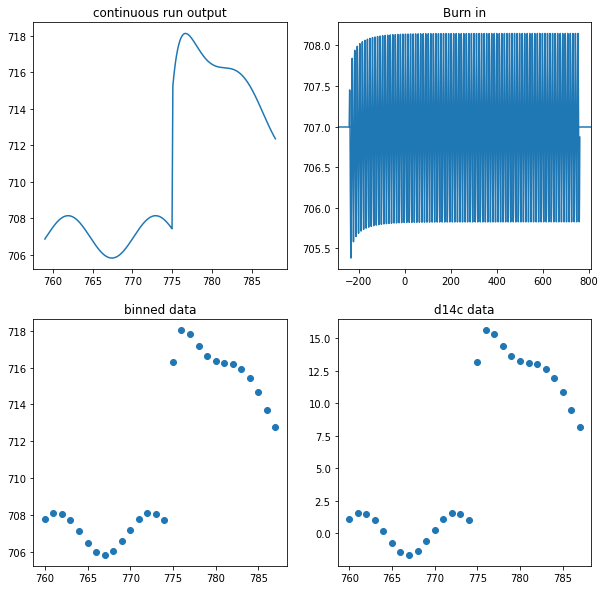

In [132]:
# working Guttler Example Graphs
# plotting continuous event
# index 1 in dimension 2 is the troposphere data

fig, axs = plt.subplots(2, 2,figsize=(10,10))
# plotting continuous event
# index 1 in dimension 2 is the troposphere data
axs[0,0].plot(d_14_time_series_fine, event1[:, 1])
axs[0,0].ticklabel_format(useOffset=False)
axs[0,0].set_title("continuous run output")

# # plotting burn in
axs[0,1].plot(burn_in_time, burn_in1[:,1])
axs[0,1].axhline(burn_in_solutions1[1]) # steady state
axs[0,1].ticklabel_format(useOffset=False)
axs[0,1].set_title("Burn in")


# # plotting binned data 
axs[1,0].plot(d_14_time_series_coarse, bin1[:,1], 'o')
axs[1,0].ticklabel_format(useOffset=False)
axs[1,0].set_title("binned data")

# # plotting d14c
axs[1,1].plot(d_14_time_series_coarse, d14c_guttler, 'o')
axs[1,1].ticklabel_format(useOffset=False)
axs[1,1].set_title("d14c data")

plt.show()

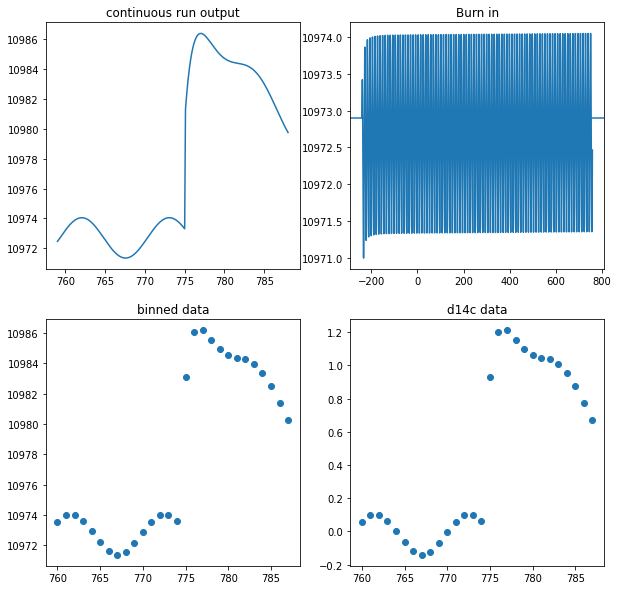

In [133]:
##### Not working Miyake Example ############

fig, axs = plt.subplots(2, 2,figsize=(10,10))
# plotting continuous event
# index 1 in dimension 2 is the troposphere data
axs[0,0].plot(d_14_time_series_fine, event4[:, 1])
axs[0,0].ticklabel_format(useOffset=False)
axs[0,0].set_title("continuous run output")

# # plotting burn in
axs[0,1].plot(burn_in_time, burn_in4[:,1])
axs[0,1].axhline(burn_in_solutions4[1]) # steady state
axs[0,1].ticklabel_format(useOffset=False)
axs[0,1].set_title("Burn in")


# # plotting binned data 
axs[1,0].plot(d_14_time_series_coarse, bin4[:,1], 'o')
axs[1,0].ticklabel_format(useOffset=False)
axs[1,0].set_title("binned data")

# # plotting d14c
axs[1,1].plot(d_14_time_series_coarse, d14c_miyake, 'o')
axs[1,1].ticklabel_format(useOffset=False)
axs[1,1].set_title("d14c data")

plt.show()

In [48]:
cbm_m._fluxes

DeviceArray([[ 0.        , 65.64019688,  0.        ,  0.        ],
             [65.64019688,  0.        , 67.62929375, 32.34444484],
             [ 0.        , 67.62929375,  0.        ,  0.        ],
             [ 0.        , 32.34444484,  0.        ,  0.        ]],            dtype=float64)

In [47]:
cbm_m.get_reservoir_contents()

DeviceArray([[ 112.5,  637.5,  900. , 1600. ]], dtype=float64)

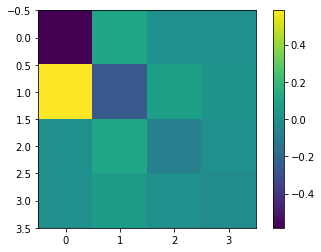

In [30]:
plt.imshow(cbm_m._matrix)
plt.colorbar()

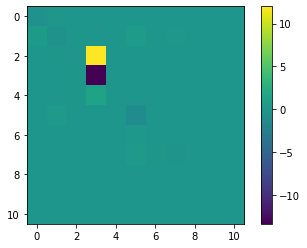

In [29]:
plt.imshow(cbm_g._matrix)
plt.colorbar()

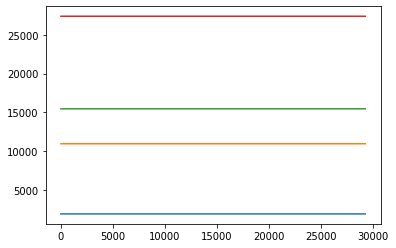

In [12]:
for j in range(4):
    plt.plot(event4[:,j])

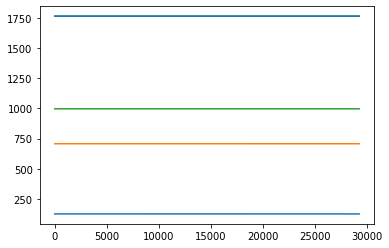

In [13]:
for j in range(11):
    plt.plot(event1[:,j])

In [14]:
cbm_m.get_fluxes()

DeviceArray([[ 0.        , 65.64019688,  0.        ,  0.        ],
             [65.64019688,  0.        , 67.62929375, 32.34444484],
             [ 0.        , 67.62929375,  0.        ,  0.        ],
             [ 0.        , 32.34444484,  0.        ,  0.        ]],            dtype=float64)

In [15]:
cbm_m._matrix = cbm_m._matrix/100.

In [16]:
cbm_g._production_rate_units

'atoms/cm^2/s'

In [17]:
d_14_time_series_coarse
oversample=1008
time_values = jnp.linspace(jnp.min(d_14_time_series_coarse) - 1, jnp.max(d_14_time_series_coarse) + 1, 
                           (d_14_time_series_coarse.shape[0] + 1) * oversample)
print(time_values)

[759.         759.0009921  759.00198419 ... 787.99801581 787.9990079
 788.        ]


(774.5, 775.5)

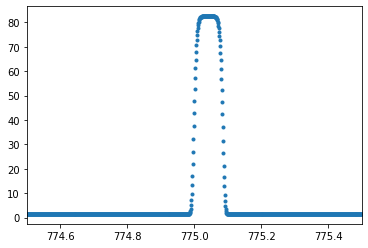

In [18]:
plt.plot(time_values,miyake_event(time_values,775, 1 / 12, np.pi / 2, 81/12, 1.8),'.')
plt.xlim(774.5,775.5)

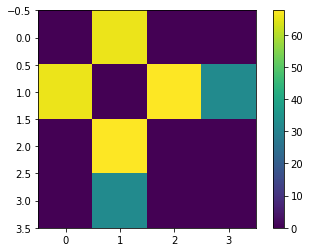

In [19]:
plt.imshow(cbm_g.get_fluxes())
plt.colorbar()

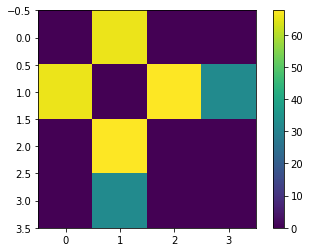

In [20]:
plt.imshow(cbm_m.get_fluxes())
plt.colorbar()

In [21]:
cbm_m.get_reservoir_contents()

DeviceArray([[ 112.5,  637.5,  900. , 1600. ]], dtype=float64)

In [22]:
cbm_g.get_reservoir_contents()

DeviceArray([[ 112.5,  637.5,  900. , 1600. ]], dtype=float64)

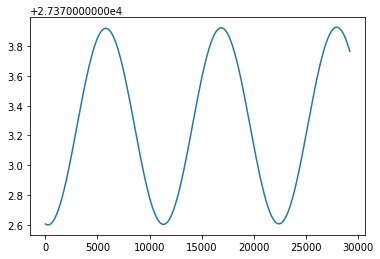

In [113]:
plt.plot(event4[:,3])